# SQL query for model

In [ ]:
"""
--This query for modelling

WITH EmployeeCTE AS (
    SELECT 
        e.[BusinessEntityID],
        e.[OrganizationLevel],
        e.[JobTitle],
        YEAR(e.[BirthDate]) AS [BirthYear],
        e.[MaritalStatus],
        e.[Gender],
        e.[HireDate],
        e.[SalariedFlag],
        e.[VacationHours],
        e.[SickLeaveHours],
        eph.[Rate],
        eph.[PayFrequency]
    FROM 
        [AdventureWorks2022].[HumanResources].[Employee] AS e
    LEFT JOIN
        [AdventureWorks2022].[HumanResources].[EmployeePayHistory] AS eph
        ON e.[BusinessEntityID] = eph.[BusinessEntityID]
),
EmployeeDepartmentHistoryCTE AS (
    SELECT 
        edh.[BusinessEntityID],
        d.[Name] AS [DepartmentName],
        d.[GroupName] AS [DepartmentGroupName],
        sh.[Name] AS [ShiftName],
        edh.[StartDate],
        edh.[EndDate]
    FROM 
        [AdventureWorks2022].[HumanResources].[EmployeeDepartmentHistory] AS edh
    LEFT JOIN
        [AdventureWorks2022].[HumanResources].[Department] AS d
        ON edh.[DepartmentID] = d.[DepartmentID]
    LEFT JOIN
        [AdventureWorks2022].[HumanResources].[Shift] AS sh
        ON edh.[ShiftID] = sh.[ShiftID]
),
SalesOrderDetailCTE AS (
    SELECT 
        sod.[SalesOrderID],
        sod.[OrderQty],
        sod.[UnitPrice],
        p.[Color],
        p.[StandardCost],
        p.[ListPrice],
        pc.[Name] AS ProductCategoryName,
        ps.[Name] AS ProductSubcategoryName
    FROM 
        [AdventureWorks2022].[Sales].[SalesOrderDetail] AS sod
    LEFT JOIN 
        [AdventureWorks2022].[Production].[Product] AS p
        ON sod.[ProductID] = p.[ProductID]
    LEFT JOIN 
        [AdventureWorks2022].[Production].[ProductSubcategory] AS ps
        ON p.[ProductSubcategoryID] = ps.[ProductSubcategoryID]
    LEFT JOIN 
        [AdventureWorks2022].[Production].[ProductCategory] AS pc
        ON ps.[ProductCategoryID] = pc.[ProductCategoryID]
)

-- Основной объединённый запрос
SELECT
    MONTH(soh.[OrderDate]) AS [OrderMonth],
    YEAR(soh.[OrderDate]) AS [OrderYear],
    st.[Name] AS [TerritoryName],
    st.[Group] AS [TerritoryGroup],
    sodcte.Color,
    sodcte.StandardCost,
    sodcte.ListPrice,
    sodcte.ProductCategoryName,
    sodcte.ProductSubcategoryName,
	soh.[TotalDue]
FROM 
    [AdventureWorks2022].[Sales].[SalesOrderHeader] AS soh
RIGHT JOIN 
    SalesOrderDetailCTE AS sodcte
    ON soh.[SalesOrderID] = sodcte.[SalesOrderID]
LEFT JOIN 
    [AdventureWorks2022].[Sales].[SalesTerritory] AS st
    ON soh.[TerritoryID] = st.[TerritoryID]
"""

# Call libraries

In [37]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge, HuberRegressor
from sklearn.preprocessing import PolynomialFeatures, OrdinalEncoder, RobustScaler
from sklearn.ensemble import StackingRegressor
from sklearn.metrics import mean_absolute_error, median_absolute_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_predict
import warnings
warnings.filterwarnings("ignore")

# Call Data

In [18]:
column_names = ['OrderMonth', 'OrderYear', 'TerritoryName', 'TerritoryGroup', "Color", "StandartCost", "ListPrice", "ProductCategoryName","ProductSubcategoryName", "TotalDue"]  # Replace with your actual column names
data = pd.read_csv("exam_model.csv", sep = ";", names=column_names, index_col=None)
data.head() 

,OrderMonth,OrderYear,TerritoryName,TerritoryGroup,Color,StandartCost,ListPrice,ProductCategoryName,ProductSubcategoryName,TotalDue
0,5,2011,Northwest,North America,Red,"13,0863","34,99",Accessories,Helmets,"16158,6961"
1,5,2011,Canada,North America,Red,"13,0863","34,99",Accessories,Helmets,"40487,7233"
2,5,2011,Northeast,North America,Red,"13,0863","34,99",Accessories,Helmets,"4216,0258"
3,5,2011,Canada,North America,Red,"13,0863","34,99",Accessories,Helmets,"8773,681"
4,5,2011,Southwest,North America,Red,"13,0863","34,99",Accessories,Helmets,"11036,3964"


In [19]:
data_replaced = data.applymap(lambda x: str(x).replace(',', '.'))
data = data_replaced

In [20]:
data['OrderMonth'] = pd.to_numeric(data['OrderMonth'], errors='coerce')
data['OrderYear'] = pd.to_numeric(data['OrderYear'], errors='coerce')
data['StandartCost'] = pd.to_numeric(data['StandartCost'], errors='coerce')
data['ListPrice'] = pd.to_numeric(data['ListPrice'], errors='coerce')
data['TotalDue'] = pd.to_numeric(data['TotalDue'], errors='coerce')

In [21]:
data.head()

,OrderMonth,OrderYear,TerritoryName,TerritoryGroup,Color,StandartCost,ListPrice,ProductCategoryName,ProductSubcategoryName,TotalDue
0,5,2011,Northwest,North America,Red,13.0863,34.99,Accessories,Helmets,16158.6961
1,5,2011,Canada,North America,Red,13.0863,34.99,Accessories,Helmets,40487.7233
2,5,2011,Northeast,North America,Red,13.0863,34.99,Accessories,Helmets,4216.0258
3,5,2011,Canada,North America,Red,13.0863,34.99,Accessories,Helmets,8773.6810
4,5,2011,Southwest,North America,Red,13.0863,34.99,Accessories,Helmets,11036.3964


In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121317 entries, 0 to 121316
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   OrderMonth              121317 non-null  int64  
 1   OrderYear               121317 non-null  int64  
 2   TerritoryName           121317 non-null  object 
 3   TerritoryGroup          121317 non-null  object 
 4   Color                   121317 non-null  object 
 5   StandartCost            121317 non-null  float64
 6   ListPrice               121317 non-null  float64
 7   ProductCategoryName     121317 non-null  object 
 8   ProductSubcategoryName  121317 non-null  object 
 9   TotalDue                121317 non-null  float64
dtypes: float64(3), int64(2), object(5)
memory usage: 9.3+ MB


In [23]:
data.describe()

,OrderMonth,OrderYear,StandartCost,ListPrice,TotalDue
count,121317.000000,121317.000000,121317.000000,121317.000000,121317.000000
mean,6.398567,2013.034768,373.686117,633.673429,24126.627959
std,3.351078,0.820866,554.114063,931.171197,32173.502712
min,1.000000,2011.000000,0.856500,2.290000,1.518300
25%,3.000000,2013.000000,9.159300,24.490000,623.750400
50%,6.000000,2013.000000,38.492300,63.500000,2785.517200
75%,9.000000,2014.000000,486.706600,782.990000,41890.970300
max,12.000000,2014.000000,2171.294200,3578.270000,187487.825000


In [24]:
data.isna().sum()

OrderMonth                0
OrderYear                 0
TerritoryName             0
TerritoryGroup            0
Color                     0
StandartCost              0
ListPrice                 0
ProductCategoryName       0
ProductSubcategoryName    0
TotalDue                  0
dtype: int64

# Feature Engineering

## Creating new features

In [25]:
data['PriceDifference'] = data['ListPrice'] - data['StandartCost']

## "OrdinalEncoder" feature

In [26]:
def OrdEnc(data, col_1, col_2):
    categ = list(data.groupby([col_1])[col_2].mean().sort_values().index)
    oe = OrdinalEncoder(categories=[categ])
    data[col_1 + "_encoded"] = oe.fit_transform(data[[col_1]])
    data[col_1 + "_encoded"] = data[col_1 + "_encoded"] + 1

In [27]:
OrdEnc(data, "TerritoryName", "TotalDue")
OrdEnc(data, "TerritoryGroup", "TotalDue")
OrdEnc(data, "Color", "TotalDue")
OrdEnc(data, "ProductCategoryName", "TotalDue")
OrdEnc(data, "ProductSubcategoryName", "TotalDue")

In [28]:
data.head()

,OrderMonth,OrderYear,TerritoryName,TerritoryGroup,Color,StandartCost,ListPrice,ProductCategoryName,ProductSubcategoryName,TotalDue,PriceDifference,TerritoryName_encoded,TerritoryGroup_encoded,Color_encoded,ProductCategoryName_encoded,ProductSubcategoryName_encoded
0,5,2011,Northwest,North America,Red,13.0863,34.99,Accessories,Helmets,16158.6961,21.9037,5.0,3.0,5.0,1.0,6.0
1,5,2011,Canada,North America,Red,13.0863,34.99,Accessories,Helmets,40487.7233,21.9037,7.0,3.0,5.0,1.0,6.0
2,5,2011,Northeast,North America,Red,13.0863,34.99,Accessories,Helmets,4216.0258,21.9037,9.0,3.0,5.0,1.0,6.0
3,5,2011,Canada,North America,Red,13.0863,34.99,Accessories,Helmets,8773.6810,21.9037,7.0,3.0,5.0,1.0,6.0
4,5,2011,Southwest,North America,Red,13.0863,34.99,Accessories,Helmets,11036.3964,21.9037,6.0,3.0,5.0,1.0,6.0


In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121317 entries, 0 to 121316
Data columns (total 16 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   OrderMonth                      121317 non-null  int64  
 1   OrderYear                       121317 non-null  int64  
 2   TerritoryName                   121317 non-null  object 
 3   TerritoryGroup                  121317 non-null  object 
 4   Color                           121317 non-null  object 
 5   StandartCost                    121317 non-null  float64
 6   ListPrice                       121317 non-null  float64
 7   ProductCategoryName             121317 non-null  object 
 8   ProductSubcategoryName          121317 non-null  object 
 9   TotalDue                        121317 non-null  float64
 10  PriceDifference                 121317 non-null  float64
 11  TerritoryName_encoded           121317 non-null  float64
 12  TerritoryGroup_e

In [30]:
data.describe()

,OrderMonth,OrderYear,StandartCost,ListPrice,TotalDue,PriceDifference,TerritoryName_encoded,TerritoryGroup_encoded,Color_encoded,ProductCategoryName_encoded,ProductSubcategoryName_encoded
count,121317.000000,121317.000000,121317.000000,121317.000000,121317.000000,121317.000000,121317.000000,121317.000000,121317.000000,121317.000000,121317.000000
mean,6.398567,2013.034768,373.686117,633.673429,24126.627959,259.987311,5.176793,2.528854,4.539842,2.298664,12.977291
std,3.351078,0.820866,554.114063,931.171197,32173.502712,380.827938,2.487299,0.705276,2.615590,1.094001,8.475530
min,1.000000,2011.000000,0.856500,2.290000,1.518300,1.433500,1.000000,1.000000,1.000000,1.000000,1.000000
25%,3.000000,2013.000000,9.159300,24.490000,623.750400,12.417700,3.000000,2.000000,1.000000,1.000000,6.000000
50%,6.000000,2013.000000,38.492300,63.500000,2785.517200,39.751000,6.000000,3.000000,5.000000,2.000000,15.000000
75%,9.000000,2014.000000,486.706600,782.990000,41890.970300,349.711600,7.000000,3.000000,7.000000,3.000000,16.000000
max,12.000000,2014.000000,2171.294200,3578.270000,187487.825000,1487.835600,10.000000,3.000000,9.000000,4.000000,35.000000


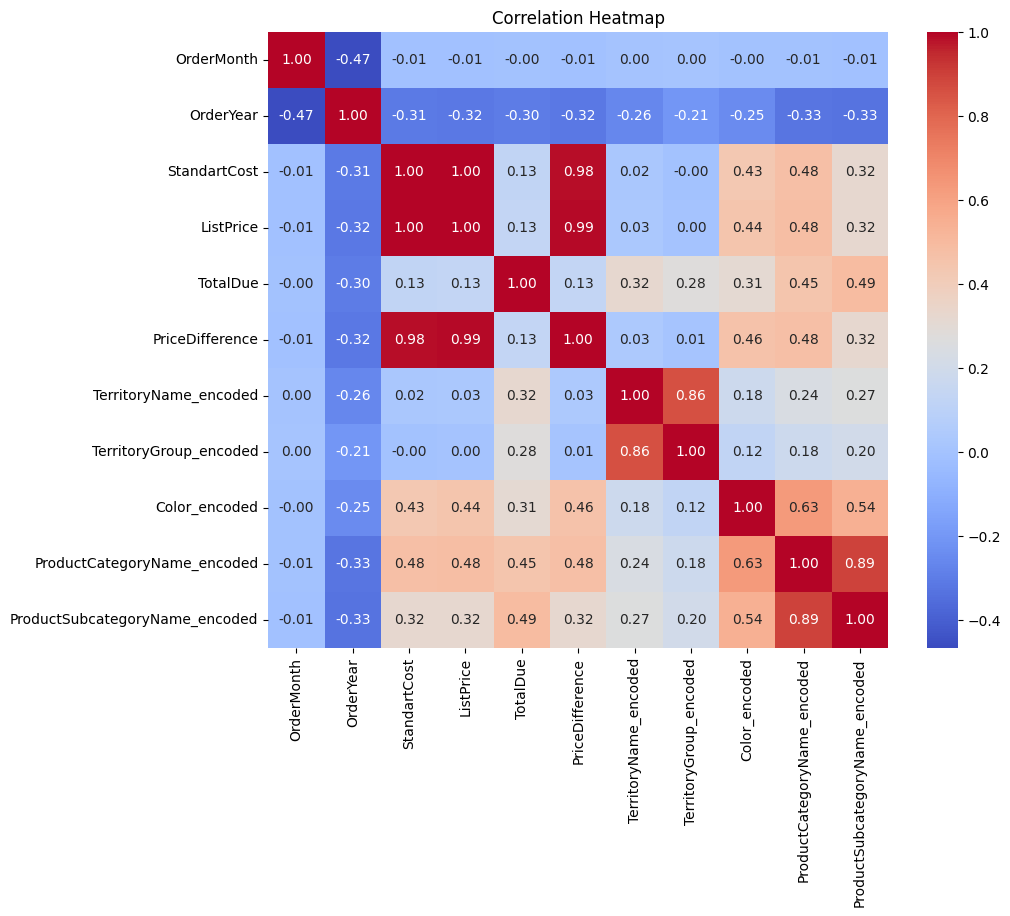

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Correlation heatmap for numeric columns
numeric_data = data.select_dtypes(include=['number'])

# Calculate correlation matrix
corr_matrix = numeric_data.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Heatmap")
plt.show()


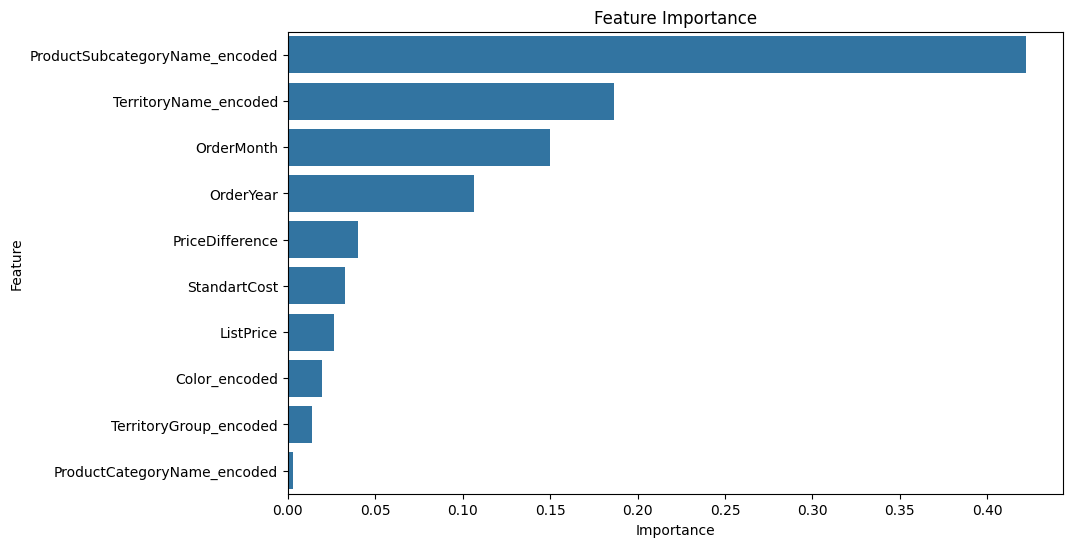

In [32]:
from sklearn.ensemble import RandomForestRegressor
import pandas as pd

# Feature importance for numeric columns
X = data.select_dtypes(include=['number']).drop('TotalDue', axis=1)
y = data['TotalDue']

# Train a Random Forest model
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X, y)

# Get feature importances
importances = rf_model.feature_importances_

# Create a DataFrame for better visualization
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title('Feature Importance')
plt.show()


# Training model in local

In [33]:
# Separate features and target
X = data.drop(['TotalDue', "TerritoryGroup_encoded","ProductCategoryName_encoded"], axis=1).select_dtypes(include=['number'])
y = data['TotalDue']

# Perform the train-test split (80% train, 20% test by default)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Output the shapes of the train and test sets
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (97053, 8)
X_test shape: (24264, 8)
y_train shape: (97053,)
y_test shape: (24264,)


In [34]:
"""
-- This code for training

import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, Ridge, Lasso, HuberRegressor
from sklearn.metrics import mean_absolute_error, median_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, PolynomialFeatures

# Models to evaluate
models = {
    'Linear': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'Huber': HuberRegressor()
}

# Function to apply polynomial features
degree = 2  # Set the degree of the polynomial features
poly = PolynomialFeatures(degree=degree)

# Apply RobustScaler to the training and test sets
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply polynomial transformation
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

# Train and evaluate each model
results = []

for name, model in models.items():
    model.fit(X_train_poly, y_train)
    y_pred = model.predict(X_test_poly)
    
    # Calculate metrics
    mae = mean_absolute_error(y_test, y_pred)
    medae = median_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mean_pred = np.mean(y_pred)
    
    results.append({
        'Model': name,
        'MAE': mae,
        'MedAE': medae,
        'R2': r2,
        'Mean Pred': mean_pred
    })

# Convert results to DataFrame for better visualization
results_df = pd.DataFrame(results)
results_df
"""

"\n-- This code for training\n\nimport numpy as np\nimport pandas as pd\nfrom sklearn.linear_model import LinearRegression, Ridge, Lasso, HuberRegressor\nfrom sklearn.metrics import mean_absolute_error, median_absolute_error, r2_score\nfrom sklearn.model_selection import train_test_split\nfrom sklearn.preprocessing import RobustScaler, PolynomialFeatures\n\n# Models to evaluate\nmodels = {\n    'Linear': LinearRegression(),\n    'Ridge': Ridge(),\n    'Lasso': Lasso(),\n    'Huber': HuberRegressor()\n}\n\n# Function to apply polynomial features\ndegree = 2  # Set the degree of the polynomial features\npoly = PolynomialFeatures(degree=degree)\n\n# Apply RobustScaler to the training and test sets\nscaler = RobustScaler()\nX_train_scaled = scaler.fit_transform(X_train)\nX_test_scaled = scaler.transform(X_test)\n\n# Apply polynomial transformation\nX_train_poly = poly.fit_transform(X_train_scaled)\nX_test_poly = poly.transform(X_test_scaled)\n\n# Train and evaluate each model\nresults = []

In [38]:
# Pipelines for each model with polynomial features and scaling
pipeline_ridge = Pipeline([
    ('scaler', RobustScaler()),               # Robust Scaling
    ('poly', PolynomialFeatures(degree=6)),   # Polynomial Features (degree 6)
    ('ridge', Ridge())
])

pipeline_lasso = Pipeline([
    ('scaler', RobustScaler()),               # Robust Scaling
    ('poly', PolynomialFeatures(degree=4)),   # Polynomial Features (degree 4)
    ('lasso', Lasso())
])

pipeline_huber = Pipeline([
    ('scaler', RobustScaler()),               # Robust Scaling
    ('poly', PolynomialFeatures(degree=3)),   # Polynomial Features (degree 3)
    ('huber', HuberRegressor())
])

pipeline_linear = Pipeline([
    ('scaler', RobustScaler()),               # Robust Scaling
    ('poly', PolynomialFeatures(degree=5)),   # Polynomial Features (degree 5)
    ('linear', LinearRegression())
])

# Stacking regressor with different models
estimators = [
    ('ridge', pipeline_ridge),
    ('lasso', pipeline_lasso),
    ('huber', pipeline_huber),
    ('linear', pipeline_linear)
]

# Final estimator is HuberRegressor
stacking_model = StackingRegressor(estimators=estimators, final_estimator=HuberRegressor(alpha=0.001))
stacking_model.fit(X_train, y_train)

# Predictions on test data
y_pred = stacking_model.predict(X_test)

# Calculating metrics
mae = mean_absolute_error(y_test, y_pred)
medae = median_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mean_pred = np.mean(y_pred)

# Create a DataFrame to display the metrics
results_df = pd.DataFrame({
    'Metric': ['MAE', 'MedAE', 'R2', 'Mean Pred'],
    'Value': [mae, medae, r2, mean_pred]
})

# Display the results DataFrame
results_df

,Metric,Value
0,MAE,15607.175412
1,MedAE,8126.462240
2,R2,0.403219
3,Mean Pred,20689.039985


In [44]:
# After fitting the model, we can extract the coefficients and intercept (bias)
coefficients = stacking_model.final_estimator_.coef_  # Coefficients for each feature
intercept = stacking_model.final_estimator_.intercept_  # Intercept (bias term)

# Forming the equation of the model
# For each coefficient, we construct the term: coeff * x_i (where i is the feature number)
equation = f"y = {intercept:.3f} + " + " + ".join([f"{coeff:.3f}*x{i+1}" for i, coeff in enumerate(coefficients)])

# Output the model's equation
print("Model Equation:")
print(equation)


Model Equation:
y = -0.001 + 0.517*x1 + -0.086*x2 + 0.133*x3 + 0.324*x4
